In [10]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd

In [11]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
data_dir_y1 = '/global/cfs/projectdirs/desi/users/zouhu/vac/dr1/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/massmag/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_sv3.fits') 

#load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [6]:
tf_mastertable[tf_mastertable['M_R26']>0]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1083283966263312,180.088777358876,-1.11024777720183,25599,sv3,0.00436762087876588,1.42837672240012e-06,0,15897.7449971626,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.08877735887648,-1.1102477772018335,1.0,0.013957389713373361,0.32999998593202395,1.0,1.0,-142.54523609053126,0.7111210610669596,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083283966263313,180.108167612631,-1.09016316641461,25599,sv3,0.0053534602140923,4.45334000484803e-06,0,4136.92135445221,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.10816761263058,-1.090163166414607,1.0,0.013957389713391206,0.3299999859324459,1.0,1.0,151.57682110136773,1.4507778336944546,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083283966263311,180.078788337759,-1.1205943454118,25599,sv3,0.00464639799063975,3.19435285822499e-05,0,31.9120003114913,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.07878833775885,-1.1205943454118001,1.0,0.02833773063017716,0.6699999714376246,1.0,1.0,-59.372963790038874,9.593243204719073,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083283966263314,180.118156429974,-1.07981649987604,25599,sv3,0.00535718577838891,1.59550379891168e-05,0,249.207345602888,fuji/healpix/sv3/dark/255/25599/redrock-sv3-dark-25599.fits,EXT,1065602,180.11815642997368,-1.0798164998760402,1.0,0.02833773063019543,0.6699999714380566,1.0,1.0,152.68833146198645,4.8167755305729365,0.00484540449738718,2153.941847415241,237.96731883800035,--,0.010000000096957435,--,1.656146404826648,--,0.6898838190982787,237.96594237599186,0.0,11.14978772214548,--,237.96714597151168,0.0,--,--,-20.645657422051553,--,--,--,--
1083338303471619,178.909990284283,1.23197064456541,27650,sv3,0.00651958780483995,6.84625673525266e-06,0,478.315322757233,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.90999028428269,1.2319706445654142,1.0,0.008001821639844116,0.3300000001109575,1.0,0.0,71.78474856081279,2.149704372108146,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,9.251432555553993,0.1567846771259586,10.083090782165527,0.07714821398229206
1083338303471618,178.897801871515,1.24234505754909,27650,sv3,0.00612525938757635,5.59810860736493e-06,0,800.964292295277,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.89780187151533,1.242345057549085,1.0,0.008001821639837198,0.33000000011067215,1.0,0.0,-45.69432851

In [13]:
# Filter the table for rows where SURVEY is 'main' and M_STELLAR_PROVABGS > 0
filtered_rows = tf_mastertable[(tf_mastertable['M_STELLAR_CIGALE'] > 0)]

# Display the filtered rows
filtered_rows

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1083338303471619,178.909990284283,1.23197064456541,27650,sv3,0.00651958780483995,6.84625673525266e-06,0,478.315322757233,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.90999028428269,1.2319706445654142,1.0,0.008001821639844116,0.3300000001109575,1.0,0.0,71.78474856081279,2.149704372108146,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,9.251432555553993,0.1567846771259586,10.083090782165527,0.07714821398229206
1083338303471618,178.897801871515,1.24234505754909,27650,sv3,0.00612525938757635,5.59810860736493e-06,0,800.964292295277,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.89780187151533,1.242345057549085,1.0,0.008001821639837198,0.33000000011067215,1.0,0.0,-45.69432851789355,1.7958968170762128,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,9.251432555553993,0.1567846771259586,10.083090782165527,0.07714821398229206
1083338303471617,178.891522954905,1.24768943021198,27650,sv3,0.00607920999660836,3.43334059685479e-05,0,13.0512072835118,fuji/healpix/sv3/dark/276/27650/redrock-sv3-dark-27650.fits,EXT,1033344,178.89152295490476,1.2476894302119814,1.0,0.016246122723326928,0.6700000002255683,1.0,0.0,-59.41345124432593,10.312728261878206,0.006278636249996695,211.54862654531604,129.61223864699448,39.06510457326381,0.30037235873465834,0.2003347199679021,2.007523784904541,3.2205654269255617,0.6344301583730204,129.52277083250448,217.8460531339156,10.492370265316927,0.6398674579079913,129.60499675938914,346.8278627144485,11.036989547658342,0.8029156501528227,-18.52505290250235,9.251432555553993,0.1567846771259586,10.083090782165527,0.07714821398229206
1083278475919362,212.91403599788,-1.20264591149526,25918,sv3,0.00548650620043427,2.41010237162794e-05,0,24.9099660143547,fuji/healpix/sv3/dark/259/25918/redrock-sv3-dark-25918.fits,EXT,975775,212.91403599788003,-1.2026459114952552,1.0,0.04502043360386291,0.6700000061965946,1.0,0.0,93.1735958797536,7.232245739593385,0.005174104459501507,372.09375209823173,142.84388647383616,32.07099649343747,0.12027930970965653,0.21912668255943454,1.2308048805549991,0.47168105371833646,1.539168277357325,142.60339563242894,132.292864722664,10.934567752119897,0.4556663037119506,142.79235193330499,187.3176113595791,11.479785956435515,0.5591446224154932,-18.268733959666427,9.060646494920567,0.02624737176229975,-999.0,--
1083278475919360,212.90471698692,-1.13610031183817,25918,sv3,0.00476559306500906,3.17150014863073e-06,0,2083.25930881174,fuji/healpix/sv3/dark/259/25918/redrock-sv3-dark-25918.fits,EXT,975775,212.90471698691962,-1.1361003118381694,1.0,0.022174243416833793,0.3300000030521403,1.0,0.0,-121.8382313397912,1.002172222359

In [3]:
#read in cigale Y1 table
cigale_1 = Table.read('/global/cfs/projectdirs/desi/users/zouhu/vac/dr1/dr1_galaxy_stellarmass_lineinfo_v1.0.fits')
#cigale['MASS_CG'] assuming this is the column I want, need to take log of all vals

In [4]:
# take base 10 log of 'MASS_CG' and 'MASSERR_CG'
cigale_1['MASS_CG'] = np.log10(cigale_1['MASS_CG'])
cigale_1['MASSERR_CG'] = np.log10(cigale_1['MASSERR_CG'])

# put target ids in list if mass exists
targets = []
target_ids = tf_mastertable['TARGETID'][tf_mastertable['M_R26'] > 0]

# find matching target ids for the table
for target_id in target_ids:
    if len(cigale_1[cigale_1['TARGETID'] == target_id]) > 0:
        targets.append(target_id)

# extract stellar masses for target ids and update tf_mastertable
for target_id in targets:
    stellar_mass = cigale_1[cigale_1['TARGETID'] == target_id]['MASS_CG'][0]
    stellar_mass_err = cigale_1[cigale_1['TARGETID'] == target_id]['MASSERR_CG'][0]
    sga_id = tf_mastertable[tf_mastertable['TARGETID'] == target_id]['SGA_ID'][0]
    tf_mastertable['M_STELLAR_CIGALE'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass
    tf_mastertable['M_STELLAR_CIGALE_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass_err

/tmp/ipykernel_1746880/3707656163.py:2: RuntimeWarning: divide by zero encountered in log10
  cigale_1['MASS_CG'] = np.log10(cigale_1['MASS_CG'])
/tmp/ipykernel_1746880/3707656163.py:3: RuntimeWarning: divide by zero encountered in log10
  cigale_1['MASSERR_CG'] = np.log10(cigale_1['MASSERR_CG'])


In [5]:
#writing new data into table
tf_mastertable.write(data_dir + 'tf_mastertable_massmag_stellar.fits', format='fits', overwrite=True)

### Plotting new cigale data

In [ ]:
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas = Table(rows=unique, names=tf_mastertable.colnames)

In [4]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
data_dir_y1 = '/global/cfs/projectdirs/desi/users/zouhu/vac/dr1/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/massmag/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_stellar.fits') 

In [5]:
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas = Table(rows=unique, names=tf_mastertable.colnames)

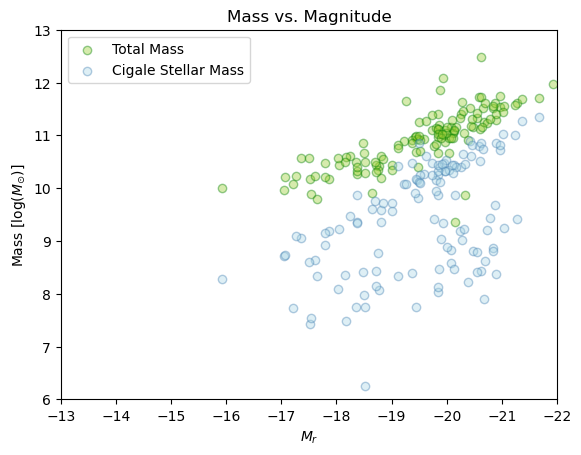

In [12]:
#total mass vs. cigale stellar mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
w = sgas['RABS_MAG26']
z = sgas['M_STELLAR_CIGALE']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'Total Mass')
plt.scatter(w, z, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(6, 13)
plt.xlim(-13, -22)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
#plt.savefig(v_dir + 'cigale_stellar_total__mass_magplot.png', dpi=300)

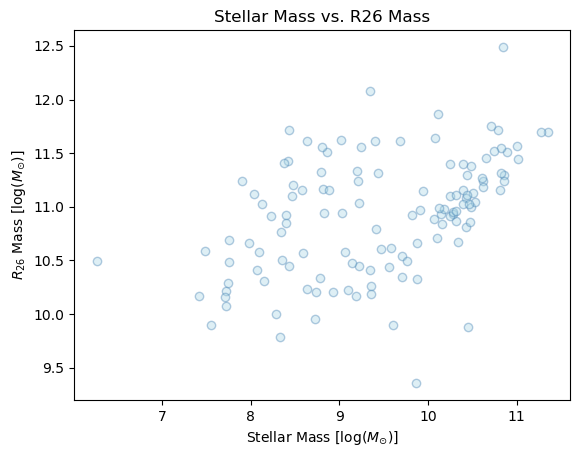

In [13]:
#stellar mass vs total mass R26 for cigale
#plotting
y = sgas['M_R26']
x_cigale = sgas['M_STELLAR_CIGALE']

#plot
plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.ylabel(r"$R_{26}$ Mass [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. R26 Mass")
plt.savefig(v_dir + 'cigale_stellar_r26__mass_plot.png', dpi=300)
plt.show()